In [131]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# 1. Test function
今回最適化するシステム(関数)を定義する。

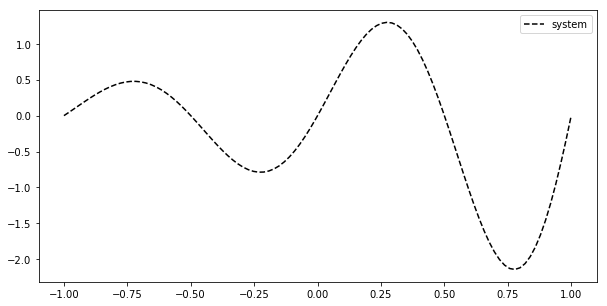

In [132]:
def my_system(x):
    xo=0.2
    return np.exp(x)*np.sin(2*np.pi*x)
#     return x-2*x**2-4*x**4+np.sin(2*np.pi*x)
my_system = np.vectorize(my_system)

def gen_x(etax):
    # recieve normalized coordinates [0-1]
    upper=1
    lower=-1
    x=(etax-0.5)*(upper-lower)
    x=x.reshape(-1,1)
    return x

etax = np.linspace(0,1,100)

xo = gen_x(etax)
yo = my_system(xo)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.legend()


# 2. 初期サンプル
初期サンプルを計算する。

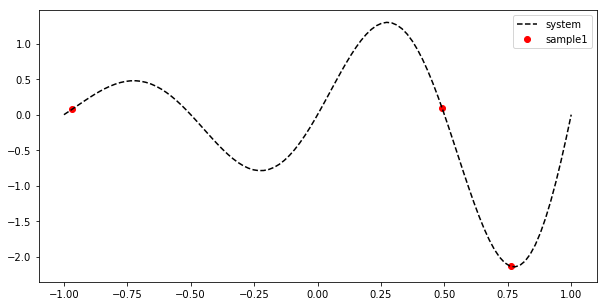

In [133]:
nsample = 3
data_eta = np.random.random_sample(size=nsample).reshape(-1,1)
xs = gen_x(data_eta)
ys = my_system(xs)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.legend()

# 3. サンプル点から関数を予測
ガウス過程を用いてサンプル点から予測分布を計算

In [134]:
#ガウス過程モデルの作成

class GaussProcess:
    
    def __init__(self, theta1=1.0, theta2=1.0 ,theta3=0.1):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        
    def fit(self, x, y):
        #サンプル点(x,y)からカーネル行列(K)を作成
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        N = len(x)
        K=np.zeros(N*N).reshape(N,-1)
        for i in range(N):
            for j in range(i, N):
                K[i,j] = theta1*np.exp(-(x[i]-x[j])**2/theta2)+theta3*int(i==j)
                K[j,i] = K[i,j]
        self.K = K
        self.xtrain = x
        self.ytrain = y
        self.Ntrain = N
    
    def predict(self,x):
        #新たなサンプル点(x)に対して予測分布(期待値、分散)を計算する。
        Ntest = len(x)
        Ntrain = self.Ntrain
        xtrain = self.xtrain
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        
        ypred = np.zeros(Ntest).reshape(Ntest,1)
        vari = np.zeros(Ntest).reshape(Ntest,1)
        
        for i in range(Ntest):
            k1 = np.zeros(Ntrain).reshape(Ntrain,1)
            for j in range(Ntrain):
                k1[j] =  theta1*np.exp((-(x[i]-xtrain[j])**2)/theta2)        
            k2 = theta1+theta3
        
            Kinv = np.linalg.inv(self.K)
            ypred[i] = k1.T.dot(Kinv).dot(self.ytrain)
            vari[i] = k2 - k1.T.dot(Kinv).dot(k1)
        
        return ypred, vari
        

In [135]:
#サンプルデータをガウス過程にフィッティング
my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

In [136]:
#新しいサンプル点に対する予測分布の計算

## 新しいサンプル点を均一に作成
etax = np.linspace(0,1,100)
xtest = gen_x(etax)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()

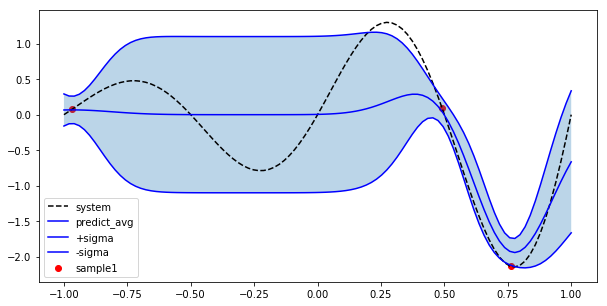

In [137]:
## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

# ４．最適解探索
目的関数を最大化するために、次に試行するべきサンプル点を探す

## 4.1 獲得関数を定義

In [138]:
# 獲得関数を定義
def afunc(xtrain,ytrain,y,vari):
    #下記論文のEI値を参考
    # https://arxiv.org/pdf/1807.02811.pdf
    maxid = np.argmax(ytrain)
    xtrainmax = xtrain[maxid]
    ytrainmax = ytrain[maxid]
    
    delta = y-ytrainmax
    deltap = np.max(delta,0)
    sigma = np.sqrt(vari)
    return deltap+sigma*norm.pdf(delta/sigma)-np.abs(delta)*norm.cdf(delta/sigma)

#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])



/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



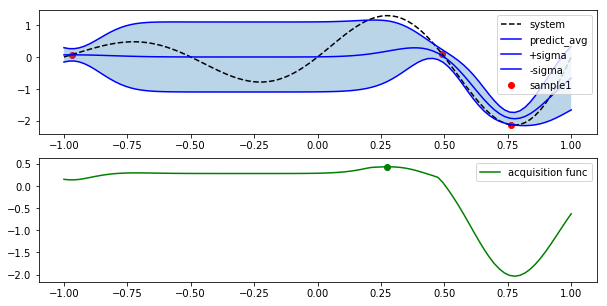

In [139]:
## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.2 次の試行その１(繰り返し)

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



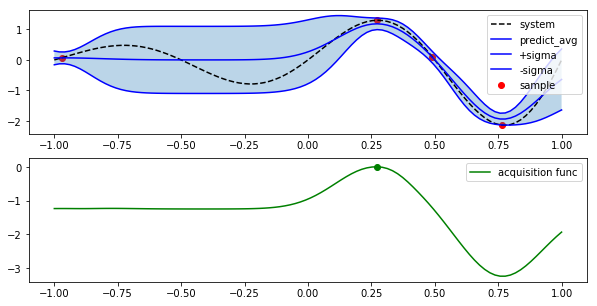

In [140]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.3 次の試行その２(繰り返し)

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



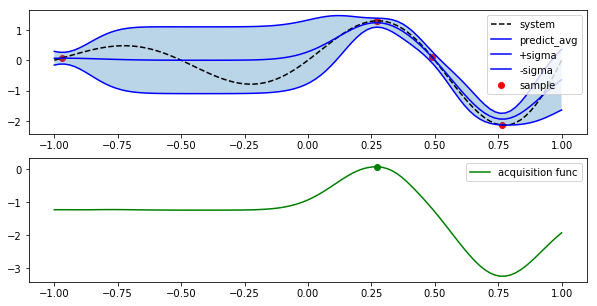

In [141]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

In [130]:
len(xs)

5

In [68]:
len(ys)

7

In [35]:
#サンプル点からのガウスカーネル計算

def gauss_kernel(x):
    # x : numpy ndarray [:,1]
    theta1 = 1.0
    theta2 = 0.1
    theta3 = 0.1
    s_size=len(x)
    K=np.zeros(s_size*s_size).reshape(s_size,-1)
    for i in range(s_size):
        for j in range(i,s_size):
            K[i,j] = theta1*np.exp(-(x[i]-x[j])**2/theta2)+theta3*int(i==j)
            K[j,i] = K[i,j]
    return K

K = gauss_kernel(xs)
    


In [36]:
#新しいサンプル点に対する予測分布の計算

## 新しいサンプル点を均一に作成
etax = np.linspace(0,1,100)
data = gen_x(etax)
xsn = data[:]
mu = np.zeros(len(xsn)).reshape(len(xsn),-1)
vari = np.zeros(len(xsn)).reshape(len(xsn),-1)

##新しいサンプル点に対するガウス分布の平均と分散を作成

def gauss_pred(xs,xo,yo,K):
    theta1 = 1.0
    theta2 = 0.1
    theta3 = 0.1
    k1 = np.zeros(len(xo)).reshape(len(xo),-1)
    for i in range(len(xo)):
        k1[i] =  theta1*np.exp((-(xs-xo[i])**2)/theta2)
    k2 = theta1*np.exp(-(xs-xs)**2/theta2)+theta3

    Kinv = np.linalg.inv(K)
    mu = k1.T.dot(Kinv).dot(yo)
    vari = k2-k1.T.dot(Kinv).dot(k1)
    return mu, vari


for i in range(len(xsn)):
    mu[i], vari[i] = gauss_pred(xsn[i], xs, ys, K)
    
y_pred = mu.flatten()
y_upr = mu+vari
y_upr = y_upr.flatten()
y_lwr = mu-vari
y_lwr = y_lwr.flatten()

In [37]:
i=0
print(f"i={i},x={xsn[i]}, mu={mu[i]}, vari={vari[i]}")

i=0,x=[-1.], mu=[0.24599182], vari=[0.71553348]


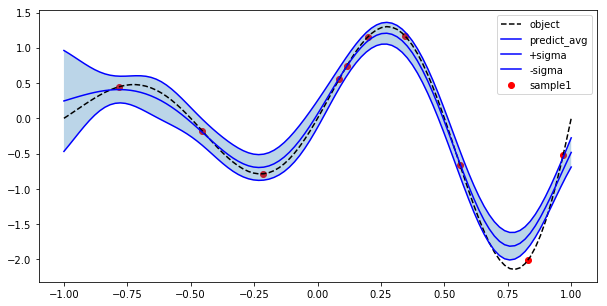

In [38]:
## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="object",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xsn,mu,label="predict_avg",color="b")
ax.plot(xsn,mu+vari,label="+sigma",color="b")
ax.plot(xsn,mu-vari,label="-sigma",color="b")
ax.fill_between(
    xsn.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

In [411]:

theta1 = 100.0
theta2 = 1.0
theta3 = 0.0
    
x=-1

k1 = np.zeros(len(xs)).reshape(len(xs),-1)
for i in range(len(xs)):
    k1[i] =  theta1*np.exp((-(x-xs[i])**2)/theta2)
k2 = theta1*np.exp(-(x-x)**2/theta2)+theta3

Kinv=np.linalg.inv(K)
mu =  k1.T.dot(Kinv).dot(ys)
sigma = k2-k1.T.dot(Kinv).dot(k1)


In [393]:
mu

array([[-32.38413463]])

In [394]:
sigma

array([[-1059.36224383]])

In [395]:
K

array([[1.00000000e+01, 6.35461936e-03, 2.15551917e-01, 9.67834725e+00],
       [6.35461936e-03, 1.00000000e+01, 3.31415035e-09, 1.64059007e-02],
       [2.15551917e-01, 3.31415035e-09, 1.00000000e+01, 1.02732245e-01],
       [9.67834725e+00, 1.64059007e-02, 1.02732245e-01, 1.00000000e+01]])

In [396]:
k1

array([[50.32119789],
       [ 5.81422685],
       [95.71577301],
       [45.62195976]])

In [354]:
k2

100.0

In [355]:
k1.T.dot(Kinv).dot(k1)

array([[97.95871545]])

In [356]:
xs

array([[-0.23308357],
       [ 0.10281982],
       [ 0.51281313],
       [ 0.00362936],
       [-0.7265547 ],
       [-0.5937149 ],
       [-0.47601448]])

In [314]:
x

-1

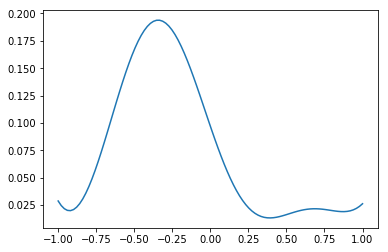

In [7]:
plt.plot(xsn,sigmas)

In [25]:
#https://qiita.com/Ringa_hyj/items/e42c726cdee25767105d

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.svm import SVR

df = px.data.iris()

#Xからの写像を作っておく

margin = 0
X = df[['sepal_width', 'sepal_length']]
y = df['petal_width']
model = SVR(C=1.)
model.fit(X, y)

#細かい点(メッシュ,グリッド)を発生

mesh_size = .02
x_min, x_max = X.sepal_width.min() - margin, X.sepal_width.max() + margin
y_min, y_max = X.sepal_length.min() - margin, X.sepal_length.max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)
#メッシュのすべての点について予測

pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)

#元の点をplotしてから、x1,x2によるgrid面をzによって押し上げる
#面は全ての点をつなぐsurfaceをつかって描く

fig = px.scatter_3d(df, x='sepal_width', y='sepal_length', z='petal_width')
fig.update_traces(marker=dict(size=5))
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface'))
fig.show()

NameError: name 'f' is not defined

In [9]:
xx

array([[2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ],
       [2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ],
       [2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ],
       ...,
       [2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ],
       [2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ],
       [2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ]])

In [12]:
len(xx.ravel())

21901

In [18]:
xx.ravel()

array([2.  , 2.02, 2.04, ..., 4.36, 4.38, 4.4 ])

In [22]:
yy.ravel()

array([4.3, 4.3, 4.3, ..., 7.9, 7.9, 7.9])

In [24]:
np.shape(xx)

(181, 121)

In [46]:
K

array([[1.        , 0.9398835 , 0.43080461, 0.30684769, 0.88563634],
       [0.9398835 , 1.        , 0.25638148, 0.16785008, 0.69977495],
       [0.43080461, 0.25638148, 1.        , 0.97175636, 0.72328706],
       [0.30684769, 0.16785008, 0.97175636, 1.        , 0.57968109],
       [0.88563634, 0.69977495, 0.72328706, 0.57968109, 1.        ]])

In [47]:
np.linalg.inv(K)

array([[ 317.42398732, -155.61953671,  230.82924297, -149.06397818,
        -252.7697981 ],
       [-155.61953671,   80.02366218, -101.87631193,   65.0217919 ,
         117.81767674],
       [ 230.82924297, -101.87631193,  260.356774  , -181.32242775,
        -216.34377634],
       [-149.06397818,   65.0217919 , -181.32242775,  129.3003481 ,
         142.7110528 ],
       [-252.7697981 ,  117.81767674, -216.34377634,  142.7110528 ,
         216.16801373]])

In [49]:
np.dot(K,np.linalg.inv(K))

array([[ 1.00000000e+00, -1.99998961e-14,  1.09590387e-14,
        -1.78944088e-14, -5.36730714e-15],
       [ 3.15017627e-14,  1.00000000e+00, -1.08303041e-14,
         1.03990473e-14, -1.37740165e-14],
       [ 1.58199644e-14, -1.06493175e-14,  1.00000000e+00,
         8.83956446e-15, -1.41048592e-14],
       [ 1.01014806e-14, -1.15436735e-14, -1.50430152e-14,
         1.00000000e+00, -2.51994431e-14],
       [ 8.52651283e-14, -1.42108547e-14,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00]])

In [21]:
#!/usr/local/bin/python
#
#    gpr.py -- Gaussian process regression.
#    $Id: gpr.py,v 1.3 2017/11/12 04:51:52 daichi Exp $
#
import sys
import putil
import numpy as np
from pylab import *
from numpy import exp,sqrt
from numpy.linalg import inv

# plot parameters
N    = 100
xmin = -1
xmax = 3.5
ymin = -1
ymax = 3

# GP kernel parameters
eta   = 0.1
tau   = 1
sigma = 1

def kgauss (params):
    [tau,sigma] = params
    return lambda x,y: tau * exp (-(x - y)**2 / (2 * sigma * sigma))

def kv (x, xtrain, kernel):
    return np.array ([kernel(x,xi) for xi in xtrain])

def kernel_matrix (xx, kernel):
    N = len(xx)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def gpr (xx, xtrain, ytrain, kernel):
    K = kernel_matrix (xtrain, kernel)
    Kinv = inv(K)
    ypr = []; spr = []
    for x in xx:
        s = kernel (x,x) + eta
        k = kv (x, xtrain, kernel)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def gpplot (xx, xtrain, ytrain, kernel, params):
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
    plot (xtrain, ytrain, 'bx', markersize=16)
    plot (xx, ypr, 'b-')
    fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color='#ccccff')


def main ():
    if len(sys.argv) < 2:
        usage ()
    else:
        train = np.loadtxt (sys.argv[1], dtype=float)
        
    xtrain = train.T[0]
    ytrain = train.T[1]
    kernel = kgauss
    params = [tau,sigma]
    xx     = np.linspace (xmin, xmax, N)

    gpplot (xx, xtrain, ytrain, kernel, params)
    
    putil.simpleaxis ()
    if len(sys.argv) > 2:
        savefig (sys.argv[2])
    else:
        show ()

if __name__ == "__main__":
    main ()

ModuleNotFoundError: No module named 'putil'